In [1]:

import json
with open('results.json', 'r') as f:
    loaded_results = json.load(f)
print()
# Ahora `loaded_results` es igual a tu lista original `results`
print(loaded_results)  # Ejemplo: acceder a la energía del primer cálculo


[{'geometry': 'H 0.0 0.0 -0.3; H 0.0 0.0 0.3;', 'energy': -1.1391732926525802, 'nuclear_repulsion': 0.8819620182000001, 'electronic_energy': -2.0211353108525802}, {'geometry': 'H 0.0 0.0 -0.35; H 0.0 0.0 0.35;', 'energy': -1.1609046798058227, 'nuclear_repulsion': 0.7559674441714287, 'electronic_energy': -1.9168721239772513}, {'geometry': 'H 0.0 0.0 -0.4; H 0.0 0.0 0.4;', 'energy': -1.162750760345864, 'nuclear_repulsion': 0.66147151365, 'electronic_energy': -1.824222273995864}, {'geometry': 'H 0.0 0.0 -0.45; H 0.0 0.0 0.45;', 'energy': -1.1540817044694682, 'nuclear_repulsion': 0.5879746788, 'electronic_energy': -1.7420563832694682}, {'geometry': 'H 0.0 0.0 -0.5; H 0.0 0.0 0.5;', 'energy': -1.1400734791679352, 'nuclear_repulsion': 0.52917721092, 'electronic_energy': -1.6692506900879351}, {'geometry': 'H 0.0 0.0 -0.75; H 0.0 0.0 0.75;', 'energy': -1.0615349493458015, 'nuclear_repulsion': 0.35278480728, 'electronic_energy': -1.4143197566258014}, {'geometry': 'H 0.0 0.0 -1.0; H 0.0 0.0 1.0

In [8]:
import numpy as np

import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC

import pyscf
from pyscf import mcscf, ao2mo


geometries = ["""H 0.0 0.0 -0.3; H 0.0 0.0 0.3;""", 
             """H 0.0 0.0 -0.35; H 0.0 0.0 0.35;""",
             """H 0.0 0.0 -0.4; H 0.0 0.0 0.4;""",
             """H 0.0 0.0 -0.45; H 0.0 0.0 0.45;""",
             """H 0.0 0.0 -0.5; H 0.0 0.0 0.5;""",
             """H 0.0 0.0 -0.75; H 0.0 0.0 0.75;""",
             """H 0.0 0.0 -1.0; H 0.0 0.0 1.0;""",
             """H 0.0 0.0 -1.25; H 0.0 0.0 1.25;""",
             """H 0.0 0.0 -1.5; H 0.0 0.0 1.5;""",
             """H 0.0 0.0 -1.75; H 0.0 0.0 1.75;""",
             """H 0.0 0.0 -2.0; H 0.0 0.0 2.0;""",
             """H 0.0 0.0 -2.25; H 0.0 0.0 2.25;""",
             """H 0.0 0.0 -2.5; H 0.0 0.0 2.5;""",
             """H 0.0 0.0 -3.0; H 0.0 0.0 3.0;""",]#Angstrom

results = []

basis = "cc-pvdz"
cas = (2, 10) # active space
unit = "angstrom"  #angstrom, bohr

for i, geometry in enumerate(geometries):
    print(f"\nProcessing geometry {i+1}:")
    print(geometry)
    #### SlowQuant
    SQobj = sq.SlowQuant()
    SQobj.set_molecule(geometry, distance_unit=unit,)
    SQobj.set_basis_set(basis)

    #### PySCF
    mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
    mf = mol.RHF().run()

    #### HF 
    mo_coeffs = mf.mo_coeff

    #### get the integrals in the AO basis
    hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
    eri_4fold_ao = mol.intor('int2e_sph')

    # OO-UCCSD
    WF = WaveFunctionUCC(
    num_elec=SQobj.molecule.number_electrons,
    cas=cas,
    mo_coeffs=mo_coeffs,
    h_ao=hcore_ao,
    g_ao=eri_4fold_ao,
    excitations="SD",
    include_active_kappa=True,
    )

    WF.run_wf_optimization_1step(
    		optimizer_name="SLSQP", 
    		tol = 1e-8,
    		orbital_optimization=True)
   
    energy = WF.energy_elec + mol.energy_nuc()
    print(f"oo-UCCSD energy for geometry {i+1} = {energy}")
    
    results.append({
        'geometry': geometry,
        'energy': energy,
        'nuclear_repulsion': mol.energy_nuc(),
        'electronic_energy': WF.energy_elec
    })





Processing geometry 1:
H 0.0 0.0 -0.3; H 0.0 0.0 0.3;
converged SCF energy = -1.10689247514485
### Parameters information:
### Number kappa: 45
### Number theta1: 9
### Number theta2: 45
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 99

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         1.78       |     -1.1132687098863001    
--------     2      |         6.18       |     -1.4664844573736002    
--------     3      |        11.86       |     -1.9560239819237348    
--------     4      |        11.34       |     -2.0116550871981569    
--------     5      |        11.84       |     -2.0178367038324341    
--------     6      |        11.39       |     -2.0209026517046129    
--------     7      |        11.93       |     -2.0209136175846334    
--------     8      |        12.25       |     -2.0207544499331638    
--------     9      |        11.77       |     -2.0210752706332245    


1 COVOs
========= Bond distance: 0.5 =========
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
========= Bond distance: 0.9 =========
========= Bond distance: 3.5 =========
========= Bond distance: 6.0 =========
========= Bond distance: 2.0 =========
========= Bond distance: 2.5 =========
========= Bond distance: 3.0 =========
========= Bond distance: 5.0 =========
========= Bond distance: 4.0 =========
========= Bond distance: 0.6 =========
========= Bond distance: 4.5 =========
========= Bond distance: 0.8 =========
========= Bond distance: 1.5 =========
[-1.0837994841939236, -1.1274394248368624, -1.153211071110685, -1.1412525824372617, -0.9797075082000004, -0.9807874881669417, -1.0080010176926537, -0.9885895729555362, -0.9811129655087228, -0.9763272849000002, -0.9786831542000005, -1.1374888977752973, -0.9778206504000004, -1.1512842109708288, -1.0531644609446569]
2 COVOs
========= Bond distance: 1.0 =========
========= Bond distance: 0.7 =========
======

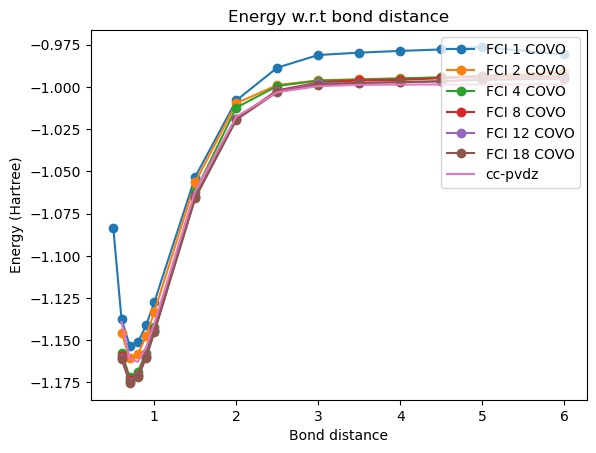

In [2]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml
from pyscf import fci
import matplotlib.pyplot as plt
import numpy as np


fcisolver = fci.direct_uhf.FCISolver()


covos = [1, 2, 4, 8, 12, 18]
data_covos = {}
for covo in covos:
    print('{} COVOs'.format(covo))
    data_dir_nwchem = os.path.join("..","H2","data_h2_pw", "3x3_aperiodic", '{}covo'.format(covo))
    data_dir_yaml = os.path.join("..","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo))
    if not os.path.exists(data_dir_yaml):
        os.makedirs(os.path.join("..","H2","data_h2_pw", "3x3_aperiodic", '{}covo_yaml'.format(covo)))
    data_files = os.listdir(data_dir_nwchem)
    bond_distances = []
    total_energies = []

    for data_file in data_files:
        if data_file.find('out') == -1:
            continue
        temp = data_file.split('-')
        temp1 = temp[1].split('.')
        bond_distance = float(temp1[0] +'.'+ temp1[1])
        bond_distances.append(bond_distance)
        name = temp[0] + '-' + str(bond_distance)
        print("========= Bond distance: {} =========".format(bond_distance))
        data_file_yaml = os.path.join(data_dir_yaml, "{}.yaml".format(name))
        data = extract_fields(os.path.join(data_dir_nwchem,data_file))
        with open(data_file_yaml, 'w') as f:
            f.write(yaml.dump(data, default_flow_style=False)) 
        
        driver = nwchem_driver.NWchem_Driver(data_file_yaml)
       
        n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(data_file_yaml, include_spin=False)
       
        energy, coefficients = fcisolver.kernel(
            h1e=(h1, h1),  
            eri=(h2, h2, h2),  
            norb=n_spatial_orbitals,
            nelec=(1, 1),
            nroots=1
        )

        total_energies.append(energy + nuclear_repulsion_energy)
    print(total_energies)

    total_energies = np.array(total_energies)
    bond_distances = np.array(bond_distances)

    sorted_indices = np.argsort(bond_distances)
    bond_distances = bond_distances[sorted_indices]
    total_energies = total_energies[sorted_indices]
    data_covos[covo] = np.array([bond_distances, total_energies])


dist = [0.6,0.7,0.8,0.9,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0,6.0]
val = [-1.13749,-1.15321,-1.15128,-1.14124,-1.12742,-1.05311,-1.00793,-0.98862,-0.98137,-0.97883,-0.97810,-0.97817,-0.97845,-0.97906]
energies = [result['energy'] for result in loaded_results]   

for covo in data_covos:
    plt.plot(data_covos[covo][0], data_covos[covo][1], 'o-', label=f'FCI {covo} COVO')
#plt.plot(dist, val, label='Paper')
plt.plot(dist,energies, label='cc-pvdz')
plt.legend(loc=1)
plt.xlabel('Bond distance')
plt.ylabel('Energy (Hartree)')
plt.title('Energy w.r.t bond distance')
#plt.ylim([-1.18,-0.8])
plt.savefig('H2_COVO.png')
plt.show()



In [3]:
print(data_covos)

{1: array([[ 0.5       ,  0.6       ,  0.7       ,  0.8       ,  0.9       ,
         1.        ,  1.5       ,  2.        ,  2.5       ,  3.        ,
         3.5       ,  4.        ,  4.5       ,  5.        ,  6.        ],
       [-1.08379948, -1.1374889 , -1.15321107, -1.15128421, -1.14125258,
        -1.12743942, -1.05316446, -1.00800102, -0.98858957, -0.98111297,
        -0.97970751, -0.97868315, -0.97782065, -0.97632728, -0.98078749]]), 2: array([[ 0.6       ,  0.7       ,  0.8       ,  0.9       ,  1.        ,
         1.5       ,  2.        ,  2.5       ,  3.        ,  3.5       ,
         4.        ,  4.5       ,  5.        ,  6.        ],
       [-1.14558229, -1.16072649, -1.15818744, -1.14755082, -1.13316035,
        -1.05647548, -1.00969778, -0.99887366, -0.99615483, -0.99542389,
        -0.99498458, -0.99435761, -0.99342583, -0.99117807]]), 4: array([[ 0.6       ,  0.7       ,  0.8       ,  0.9       ,  1.        ,
         1.5       ,  2.        ,  2.5       ,  3.        ,

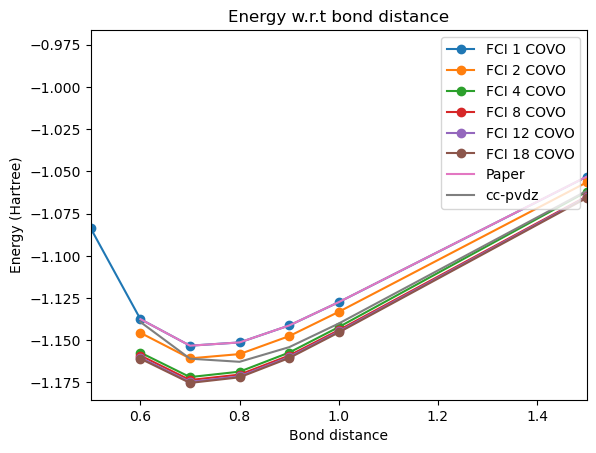

In [4]:
for covo in data_covos:
    plt.plot(data_covos[covo][0], data_covos[covo][1], 'o-', label=f'FCI {covo} COVO')
plt.plot(dist, val, label='Paper')
plt.plot(dist,energies, label='cc-pvdz')
plt.legend(loc=1)
plt.xlabel('Bond distance')
plt.ylabel('Energy (Hartree)')
plt.title('Energy w.r.t bond distance')
plt.xlim([0.5,1.5])
#.ylim([-1.100, -0.970])
plt.savefig('H2_COVO_.png')
plt.show()


In [43]:
import os
from qiskit_nwchem_driver.nwchem2yaml import extract_fields
from qiskit_nwchem_driver import nwchem_driver
import yaml



data_dir = os.path.join("..","data","PW_LiH_data", "3x3_periodic", "NWChem",'1covo')
datafile = os.path.join(data_dir, "H1Li1-2.0.out")
data_file_yaml = os.path.join(data_dir, "H1Li1-2.0.yaml")

data = extract_fields(datafile)
with open(data_file_yaml, 'w') as f:
    f.write(yaml.dump(data, default_flow_style=False)) 

driver = nwchem_driver.NWchem_Driver(data_file_yaml)

n_electrons, n_spatial_orbitals, nuclear_repulsion_energy, h1, h2 = driver.load_from_yaml(data_file_yaml, include_spin=True)
#print(h1)
print(n_electrons)
#print(h2)
#print(h2.shape
#print(nuclear_repulsion_energy)




2


In [44]:
mo_coeffs_ = np.identity(4)

WF_ = WaveFunctionUCC(
num_elec=n_electrons,
cas=(2,6),
mo_coeffs=mo_coeffs_,
h_ao=h1,
g_ao=h2,
excitations="SD",
include_active_kappa=True,
)


WF_.run_wf_optimization_1step(
		optimizer_name="SLSQP", 
		tol = 1e-8,
		orbital_optimization=False)
angles = WF.thetas
#print(angles)
print("oo-UCCSD energy in MO representation = ",WF_.energy_elec)
print()
#print("difference = ", WF.energy_elec-WF_.energy_elec)

### Parameters information:
### Number kappa: 6
### Number theta1: 3
### Number theta2: 6
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 15

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         0.05       |     -0.8745725707061057    
--------     2      |         0.09       |     -1.1058175009703226    
--------     3      |         0.08       |     -1.1059777950538274    
--------     4      |         0.09       |     -1.1059885631165927    
--------     5      |         0.06       |     -1.1059886098495575    
--------     6      |         0.05       |     -1.1059886098495575    
oo-UCCSD energy in MO representation =  -1.1059886098495575



In [40]:
import numpy as np

import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC

import pyscf
from pyscf import mcscf, ao2mo


geometry = """Li 0.0 0.0 -1.0; H 0.0 0.0 1.0;""" #Angstrom
basis = "cc-pvdz"
cas = (2, 4) # active space
unit = "angstrom"  #angstrom, bohr

#### SlowQuant
SQobj = sq.SlowQuant()
SQobj.set_molecule(geometry, distance_unit=unit,)
SQobj.set_basis_set(basis)

#### PySCF
mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
mf = mol.RHF().run()

#### HF 
mo_coeffs = mf.mo_coeff
#print(mo_coeffs)
#print(mo_coeffs.shape)
#print(len(mo_coeffs))

#### get the integrals in the AO basis
hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
eri_4fold_ao = mol.intor('int2e_sph')
#print(hcore_ao)

# OO-UCCSD
WF = WaveFunctionUCC(
num_elec=SQobj.molecule.number_electrons,
cas=cas,
mo_coeffs=mo_coeffs,
h_ao=hcore_ao,
g_ao=eri_4fold_ao,
excitations="SD",
include_active_kappa=True,
)

WF.run_wf_optimization_1step(
		optimizer_name="SLSQP", 
		tol = 1e-8,
		orbital_optimization=True)



print("oo-UCCSD energy =",WF.energy_elec + mol.energy_nuc())
print()
print("Now let's try to run it again but using the integrals in the MO basis, and not the AO.") 
print()

hcore_mo = np.einsum('pi,pq,qj->ij', mo_coeffs, hcore_ao, mo_coeffs)
eri_4fold_mo = ao2mo.incore.full(eri_4fold_ao, mo_coeffs)
mo_coeffs_ = np.identity(len(mo_coeffs))

# OO-UCCSD
WF_ = WaveFunctionUCC(
num_elec=SQobj.molecule.number_electrons,
cas=cas,
mo_coeffs=mo_coeffs_,
h_ao=hcore_mo,
g_ao=eri_4fold_mo,
excitations="SD",
include_active_kappa=True,
)

WF_.run_wf_optimization_1step(
		optimizer_name="SLSQP", 
		tol = 1e-8,
		orbital_optimization=True)

print("oo-UCCSD energy in MO representation = ",WF_.energy_elec + mol.energy_nuc())
print()
print("difference = ", WF.energy_elec-WF_.energy_elec)
 

converged SCF energy = -7.9720520404437
### Parameters information:
### Number kappa: 80
### Number theta1: 3
### Number theta2: 6
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 89

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         0.24       |     -8.7660400757619339    
--------     2      |         0.18       |     -8.7660780401608491    
--------     3      |         0.21       |     -8.7660813168933274    
--------     4      |         0.19       |     -8.7660602393932319    
--------     5      |         0.36       |     -8.7659391846431980    
--------     6      |         0.30       |     -8.7661063866958209    
--------     7      |         0.29       |     -8.7662868895524539    
--------     8      |         0.24       |     -7.5972516316730481    
--------     9      |         0.56       |     -3.7168973427312726    
--------     10     |         0.70       |     -8.4689652

In [1]:
import numpy as np

import slowquant.SlowQuant as sq
from slowquant.unitary_coupled_cluster.ucc_wavefunction import WaveFunctionUCC

import pyscf
from pyscf import mcscf, ao2mo


geometry = """H 0.0 0.0 0.0; H 0.0 0.0 0.7414;""" #Angstrom
basis = "cc-pvdz"
cas = (2, 6) # active space
unit = "angstrom"  #angstrom, bohr

#### SlowQuant
SQobj = sq.SlowQuant()
SQobj.set_molecule(geometry, distance_unit=unit,)
SQobj.set_basis_set(basis)

#### PySCF
mol = pyscf.M(atom = geometry, basis = basis, unit = unit)
mf = mol.RHF().run()

#### HF 
mo_coeffs = mf.mo_coeff

#### get the integrals in the AO basis
hcore_ao = mol.intor_symmetric('int1e_kin') + mol.intor_symmetric('int1e_nuc')
eri_4fold_ao = mol.intor('int2e_sph')

# OO-UCCSD
WF = WaveFunctionUCC(
num_elec=SQobj.molecule.number_electrons,
cas=cas,
mo_coeffs=mo_coeffs,
h_ao=hcore_ao,
g_ao=eri_4fold_ao,
excitations="SD",
include_active_kappa=True,
)

WF.run_wf_optimization_1step(
		optimizer_name="SLSQP", 
		tol = 1e-8,
		orbital_optimization=True)



print("oo-UCCSD energy =",WF.energy_elec + mol.energy_nuc())
print()
print("Now let's try to run it again but using the integrals in the MO basis, and not the AO.") 
print()

hcore_mo = np.einsum('pi,pq,qj->ij', mo_coeffs, hcore_ao, mo_coeffs)
eri_4fold_mo = ao2mo.incore.full(eri_4fold_ao, mo_coeffs)
mo_coeffs_ = np.identity(len(mo_coeffs))


# OO-UCCSD
WF_ = WaveFunctionUCC(
num_elec=SQobj.molecule.number_electrons,
cas=cas,
mo_coeffs=mo_coeffs_,
h_ao=hcore_mo,
g_ao=eri_4fold_mo,
excitations="SD",
include_active_kappa=True,
)

WF_.run_wf_optimization_1step(
		optimizer_name="SLSQP", 
		tol = 1e-8,
		orbital_optimization=True)

print("oo-UCCSD energy in MO representation = ",WF_.energy_elec + mol.energy_nuc())
print()
print("difference = ", WF.energy_elec + mol.energy_nuc() - WF_.energy_elec - mol.energy_nuc() )


converged SCF energy = -1.12871495902965
### Parameters information:
### Number kappa: 39
### Number theta1: 5
### Number theta2: 15
### Number theta3: 0
### Number theta4: 0
### Number theta5: 0
### Number theta6: 0
### Total parameters: 59

Iteration # | Iteration time [s] | Electronic energy [Hartree]
--------     1      |         0.28       |     -1.5151245907563720    
--------     2      |         0.51       |     -1.8563689465780031    
--------     3      |         0.68       |     -1.8720083231584197    
--------     4      |         0.75       |     -1.8726324498992775    
--------     5      |         0.70       |     -1.8737407701247046    
--------     6      |         0.53       |     -1.8742175244194672    
--------     7      |         0.52       |     -1.8738397904950514    
--------     8      |         0.74       |     -1.8745393780503030    
--------     9      |         0.75       |     -1.8746873617324156    
--------     10     |         0.49       |     -1.87481